In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import statistics 
from tqdm import tqdm

In [2]:
viscosity = pd.read_excel("viscosity_v5_100.xlsx")

In [28]:
viscosity

,Glass_ID,SiO2,B2O3,Al2O3,MgO,CaO,BaO,Li2O,Na2O,K2O,Rb2O,Cs2O,BeO,MnO,FeO,CoO,NiO,CuO,ZnO,SrO,CdO,PbO,SnO,Cr2O3,Fe2O3,Ga2O3,As2O3,Y2O3,In2O3,Sb2O3,La2O3,Nd2O3,Gd2O3,Bi2O3,Co2O3,Sc2O3,Co3O4,Mn3O4,Fe3O4,TiO2,MnO2,GeO2,ZrO2,CeO2,SnO2,TeO2,P2O5,V2O5,Nb2O5,Ta2O5,SO3,MoO3,WO3,H2O,log 10 value,Temperature_C,prop_id,unit,note,source
0,26,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,3.314710,1000.0,1210,Poise,NaN,inter
1,26,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,2.867526,1100.0,1211,Poise,NaN,inter
2,26,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,2.484157,1200.0,1212,Poise,NaN,inter
3,26,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,2.149527,1300.0,1213,Poise,NaN,inter
4,26,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1.854913,1400.0,1214,Poise,NaN,inter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98156,1011794,72.320000,0.00,9.99,0.050000,1.97,0.00,0.0,12.680,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.94,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,3.167328,1500.0,1215,Poise,NaN,sci
98157,1011794,72.320000,0.00,9.99,0.050000,1.97,0.00,0.0,12.680,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.94,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.787533,1600.0,1216,Poise,NaN,sci
98158,1032638,66.629997,0.00,13.77,16.290001,1.17,0.00,0.0,0.021,0.076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.956759,1400.0,1214,Poise,NaN,sci
98159,1032638,66.629997,0.00,13.77,16.290001,1.17,0.00,0.0,0.021,0.076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.449131,1500.0,1215,Poise,NaN,sci


In [3]:
X_idx=[]
for i in range(1,54):
  X_idx.append(i)
X_idx.append(55)

In [30]:
testing = viscosity.drop(range(9861,88305)).iloc[:,X_idx]
testing 

,SiO2,B2O3,Al2O3,MgO,CaO,BaO,Li2O,Na2O,K2O,Rb2O,Cs2O,BeO,MnO,FeO,CoO,NiO,CuO,ZnO,SrO,CdO,PbO,SnO,Cr2O3,Fe2O3,Ga2O3,As2O3,Y2O3,In2O3,Sb2O3,La2O3,Nd2O3,Gd2O3,Bi2O3,Co2O3,Sc2O3,Co3O4,Mn3O4,Fe3O4,TiO2,MnO2,GeO2,ZrO2,CeO2,SnO2,TeO2,P2O5,V2O5,Nb2O5,Ta2O5,SO3,MoO3,WO3,H2O,Temperature_C
0,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1000.0
1,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1100.0
2,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1200.0
3,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1300.0
4,66.199997,4.34,1.81,4.740000,7.15,0.96,0.0,13.630,0.980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98156,72.320000,0.00,9.99,0.050000,1.97,0.00,0.0,12.680,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.94,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1500.0
98157,72.320000,0.00,9.99,0.050000,1.97,0.00,0.0,12.680,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.94,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1600.0
98158,66.629997,0.00,13.77,16.290001,1.17,0.00,0.0,0.021,0.076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1400.0
98159,66.629997,0.00,13.77,16.290001,1.17,0.00,0.0,0.021,0.076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1500.0


In [38]:
training = viscosity.iloc[9861:88305,X_idx]
training

,SiO2,B2O3,Al2O3,MgO,CaO,BaO,Li2O,Na2O,K2O,Rb2O,Cs2O,BeO,MnO,FeO,CoO,NiO,CuO,ZnO,SrO,CdO,PbO,SnO,Cr2O3,Fe2O3,Ga2O3,As2O3,Y2O3,In2O3,Sb2O3,La2O3,Nd2O3,Gd2O3,Bi2O3,Co2O3,Sc2O3,Co3O4,Mn3O4,Fe3O4,TiO2,MnO2,GeO2,ZrO2,CeO2,SnO2,TeO2,P2O5,V2O5,Nb2O5,Ta2O5,SO3,MoO3,WO3,H2O,Temperature_C
9861,62.799999,4.60,10.70,9.22,9.22,3.46,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1100.0
9862,65.029999,12.30,10.40,2.45,4.91,2.45,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.45,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1041.0
9863,64.980003,5.66,9.91,0.00,13.80,5.66,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0
9864,65.980003,4.66,9.91,0.00,13.80,5.66,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1080.0
9865,74.110001,0.00,12.29,2.92,0.00,0.32,6.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.8,0.00,0.0,0.0,0.0,0.0,0.02,0.0,0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88300,65.300003,0.50,15.40,2.20,0.00,0.00,0.00,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0
88301,65.300003,0.50,15.40,2.20,0.00,0.00,0.00,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0
88302,65.300003,0.50,15.40,2.20,0.00,0.00,0.00,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400.0
88303,65.300003,0.50,15.40,2.20,0.00,0.00,0.00,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0


In [44]:
training_remove = list((np.argwhere(np.isnan(np.array(training.iloc[:,53]))).reshape(-1))+9861)

In [48]:
X_traindf = training.drop(training_remove)

In [49]:
np.argwhere(np.isnan(np.array(X_traindf.iloc[:,53]))).reshape(-1)

array([], dtype=int64)

In [64]:
y_traindf = viscosity.iloc[9861:88305,54].drop(training_remove)
np.isnan(y_traindf).sum()

0

In [50]:
testing_remove = list((np.argwhere(np.isnan(np.array(testing.iloc[:,53]))).reshape(-1)))

In [52]:
X_testdf = testing.drop(testing_remove)

In [53]:
np.argwhere(np.isnan(np.array(X_testdf.iloc[:,53]))).reshape(-1)

array([], dtype=int64)

In [65]:
y_testdf = viscosity.drop(range(9861,88305)).iloc[:,54].drop(testing_remove)
np.isnan(y_testdf).sum()

0

In [66]:
X_train = np.array(X_traindf)

In [68]:
y_train = np.array(y_traindf).reshape(-1)

In [69]:
X_train = torch.tensor(X_train, device="cuda").type(torch.float)
y_train = torch.tensor(y_train, device="cuda").type(torch.float)

In [70]:
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)
y_mean = y_train.mean(dim=0)
y_std = y_train.std(dim=0)
X_mean.shape, X_std.shape, y_mean.shape, y_std.shape

(torch.Size([54]), torch.Size([54]), torch.Size([]), torch.Size([]))

In [71]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        if self.target_transform is not None:
            y = self.target_transform(y)
        return X, y

In [72]:
training_set = CustomDataset(X_train, 
                             y_train, 
                             transform=lambda X: ((X - X_mean)/X_std), 
                             target_transform=lambda y: ((y - y_mean)/y_std)
                          )



In [74]:
net = torch.nn.Sequential(
    torch.nn.Linear(54, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(256, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),   
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(64, 1))

batch_size = 128
epoch_total = 100


def lr_lambda(epoch):
 
    lr=0.01    
    return lr

optimizer = torch.optim.Adam([param for param in net.parameters() if param.requires_grad], lr=0.01, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_func = torch.nn.MSELoss(reduction="none") 

train_loader = DataLoader(
    dataset=training_set,
    batch_size=batch_size, 
    shuffle=True)



net = net.cuda()

train_losses = []
train_r2 = []
# start training

for epoch in range(epoch_total):
    # print('Epoch = %d' % epoch + 1)
    net.train()
    train_targets = []
    train_predictions = []
    total_loss = None
    for step, (batch_X, batch_y) in enumerate(train_loader): # for each training step
        optimizer.zero_grad()   # clear gradients for next train
        prediction = net(batch_X).squeeze(dim=1) 
          # input x and predict based on x
        loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
        current_loss = loss.sum()

        if total_loss is None:
            total_loss = current_loss
        else:
            total_loss += current_loss
        
        loss = loss.mean()
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        train_targets += [batch_y]
        train_predictions += [prediction]
    
    with torch.no_grad():
        train_targets = torch.cat(train_targets, dim=0)
        train_predictions = torch.cat(train_predictions, dim=0)
        total_loss = total_loss / train_targets.shape[0]
        train_losses += [total_loss.item()]
        train_r2.append(sklearn.metrics.r2_score((train_targets * y_std + y_mean).cpu().numpy(), (train_predictions * y_std + y_mean).cpu().numpy()))
        print('Epoch %d: Training Loss = %.4f' % (epoch + 1, total_loss.item()))


    lr_scheduler.step()


Epoch 1: Training Loss = 0.3335
Epoch 2: Training Loss = 0.1945
Epoch 3: Training Loss = 0.1655
Epoch 4: Training Loss = 0.1508
Epoch 5: Training Loss = 0.1398
Epoch 6: Training Loss = 0.1310
Epoch 7: Training Loss = 0.1232
Epoch 8: Training Loss = 0.1213
Epoch 9: Training Loss = 0.1156
Epoch 10: Training Loss = 0.1115
Epoch 11: Training Loss = 0.1090
Epoch 12: Training Loss = 0.1075
Epoch 13: Training Loss = 0.1012
Epoch 14: Training Loss = 0.1015
Epoch 15: Training Loss = 0.0978
Epoch 16: Training Loss = 0.0970
Epoch 17: Training Loss = 0.0947
Epoch 18: Training Loss = 0.0926
Epoch 19: Training Loss = 0.0935
Epoch 20: Training Loss = 0.0887
Epoch 21: Training Loss = 0.0896
Epoch 22: Training Loss = 0.0894
Epoch 23: Training Loss = 0.0863
Epoch 24: Training Loss = 0.0862
Epoch 25: Training Loss = 0.0840
Epoch 26: Training Loss = 0.0831
Epoch 27: Training Loss = 0.0817
Epoch 28: Training Loss = 0.0826
Epoch 29: Training Loss = 0.0809
Epoch 30: Training Loss = 0.0781
Epoch 31: Training 

In [75]:
X_test = np.array(X_testdf)

In [76]:
y_test = np.array(y_testdf).reshape(-1)

In [77]:
X_test = torch.tensor(X_test, device="cuda").type(torch.float)
y_test = torch.tensor(y_test, device="cuda").type(torch.float)

In [78]:
test_set = CustomDataset(X_test,
                        y_test,
                        transform=lambda X: ((X - X_mean)/X_std), 
                        target_transform=lambda y: ((y - y_mean)/y_std)
                    )

In [79]:
test_r2=[]
test_losses=[]

In [80]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size, 
    shuffle=False)

with torch.no_grad():
    net.eval()
    test_targets = []
    test_predictions = []
    total_loss = None
    for (batch_X, batch_y) in test_loader: # for each training step
        prediction = net(batch_X).squeeze(dim=1)     # input x and predict based on x
        current_loss = loss_func(prediction, batch_y).sum()
        if total_loss is None:
            total_loss = current_loss
        else:
            total_loss += current_loss
        test_targets += [batch_y]
        test_predictions += [prediction]
    test_targets = torch.cat(test_targets, dim=0)
    test_predictions = torch.cat(test_predictions, dim=0)
    test_r2.append(sklearn.metrics.r2_score((test_targets * y_std + y_mean).cpu().numpy(), (test_predictions * y_std + y_mean).cpu().numpy()))
    
    total_loss = total_loss / test_targets.shape[0]
    test_losses.append(total_loss.item())
    print("Epoch %d: Validation Loss = %.4f" % (epoch + 1, total_loss.item()))

Epoch 100: Validation Loss = 0.1828


In [81]:
test_r2

[0.8662637659759953]

In [86]:
train_r2

[0.6665318101895057,
 0.8054920426692512,
 0.8345413923066569,
 0.8492221188860658,
 0.860210120403468,
 0.8689932682137891,
 0.8767678205947993,
 0.8787223870744697,
 0.8843643575915405,
 0.8884882626339028,
 0.8909931912395246,
 0.8925331681580396,
 0.8987979225771494,
 0.8985046079677151,
 0.902217106898766,
 0.9030019585982617,
 0.9052816898923411,
 0.9073788187140809,
 0.9065205685300435,
 0.9112983215752967,
 0.9104219914531162,
 0.9105918682835668,
 0.9137205775009669,
 0.9138150092094789,
 0.9159787415445706,
 0.916856547176094,
 0.9183320732363615,
 0.9174221533630813,
 0.919097787885806,
 0.9218928406934069,
 0.9198629293968386,
 0.9225445045004091,
 0.9215104284464982,
 0.9228993775989736,
 0.922668584282384,
 0.9236675932250658,
 0.9241402945536831,
 0.9247006439477019,
 0.9251353790264515,
 0.9264033649962714,
 0.9289064057286509,
 0.9256822050190627,
 0.9282126218111209,
 0.9282037995266771,
 0.9282125909471943,
 0.9279046442423159,
 0.9295196608537599,
 0.928440948512804

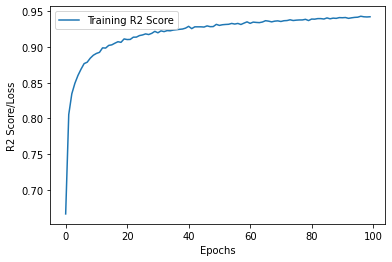

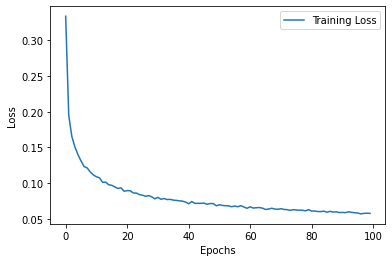

In [83]:
plt.plot(train_r2, label="Training R2 Score")
plt.ylabel('R2 Score/Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(train_losses, label="Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

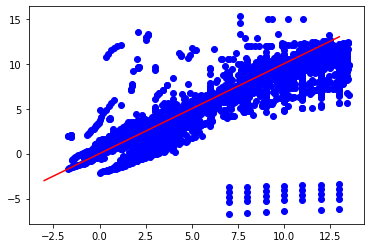

In [84]:
plt.plot((test_targets * y_std + y_mean).cpu().numpy(), (test_predictions * y_std + y_mean).cpu().numpy(),'bo')
plt.plot([-3,13],[-3,13],'red'
)

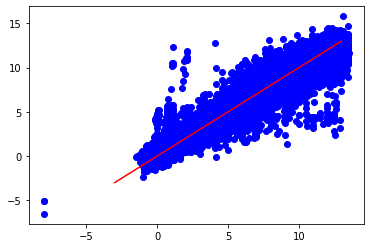

In [85]:
plt.plot((train_targets * y_std + y_mean).cpu().numpy(), (train_predictions * y_std + y_mean).cpu().numpy(),'bo')
plt.plot([-3,13],[-3,13],'red'
)